In [1]:
!hydromt build sfincs "./sfincs_vientiane_model" "{'bbox': [101.9853,17.7788,103.1368,18.4542]}" -r 100 -i vientiane_sfincs.ini -vv --dd

2022-07-12 09:46:18,850 - build - log - DEBUG - Writing log messages to new file C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\sfincs_vientiane_model\hydromt.log.
2022-07-12 09:46:18,851 - build - log - INFO - HydroMT version: 0.4.5
2022-07-12 09:46:18,851 - build - main - INFO - Building instance of sfincs model at C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\sfincs_vientiane_model.
2022-07-12 09:46:18,851 - build - main - INFO - User settings:
2022-07-12 09:46:18,883 - build - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1)
2022-07-12 09:46:18,884 - build - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1).
2022-07-12 09:46:18,884 - build - data_adapter - INFO - Adding deltares_data v0.0.6 sources from https://github.com/DirkEilander/hydromt-artifacts/releases/download/v0.0.6/deltares_data.yml
2022-07-12 09:46:20,403 - build - model_api - DEBUG - Setting model config options.
2022-

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.



2022-07-12 09:52:31,733 - build - data_adapter - INFO - DataCatalog: Getting vientiane_pluvial_gauges GeoDataFrame csv data from C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\data\vientiane_pluvial_gauges.csv
2022-07-12 09:52:31,735 - build - data_adapter - INFO - GeoDataFrame: Read csv data and clip to geom (epsg:4326) [101.985, 17.779, 103.137, 18.454].
2022-07-12 09:52:31,886 - build - sfincs - INFO - obs set based on C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\data\vientiane_pluvial_gauges.csv
2022-07-12 09:52:31,888 - build - model_api - INFO - setup_p_forcing_from_grid.precip_fn: era5_hourly
2022-07-12 09:52:31,888 - build - model_api - INFO - setup_p_forcing_from_grid.dst_res: None
2022-07-12 09:52:31,888 - build - model_api - INFO - setup_p_forcing_from_grid.aggregate: False
2022-07-12 09:52:31,888 - build - data_adapter - INFO - DataCatalog: Getting era5_hourly RasterDataset netcdf data from p:\wflow_global\hydromt\meteo\era5\{variable}\era5_{v

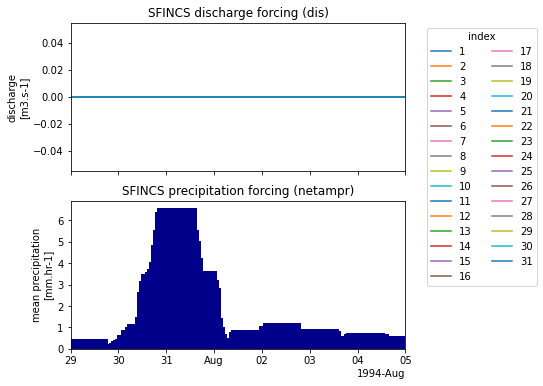

In [2]:
%matplotlib inline
from hydromt_sfincs import SfincsModel
import matplotlib.pyplot as plt
mod = SfincsModel(root="sfincs_vientiane_model", mode="r")
#mod.forcing.pop('bzs', None)  # let's focus on precip for now
_ = mod.plot_forcing()

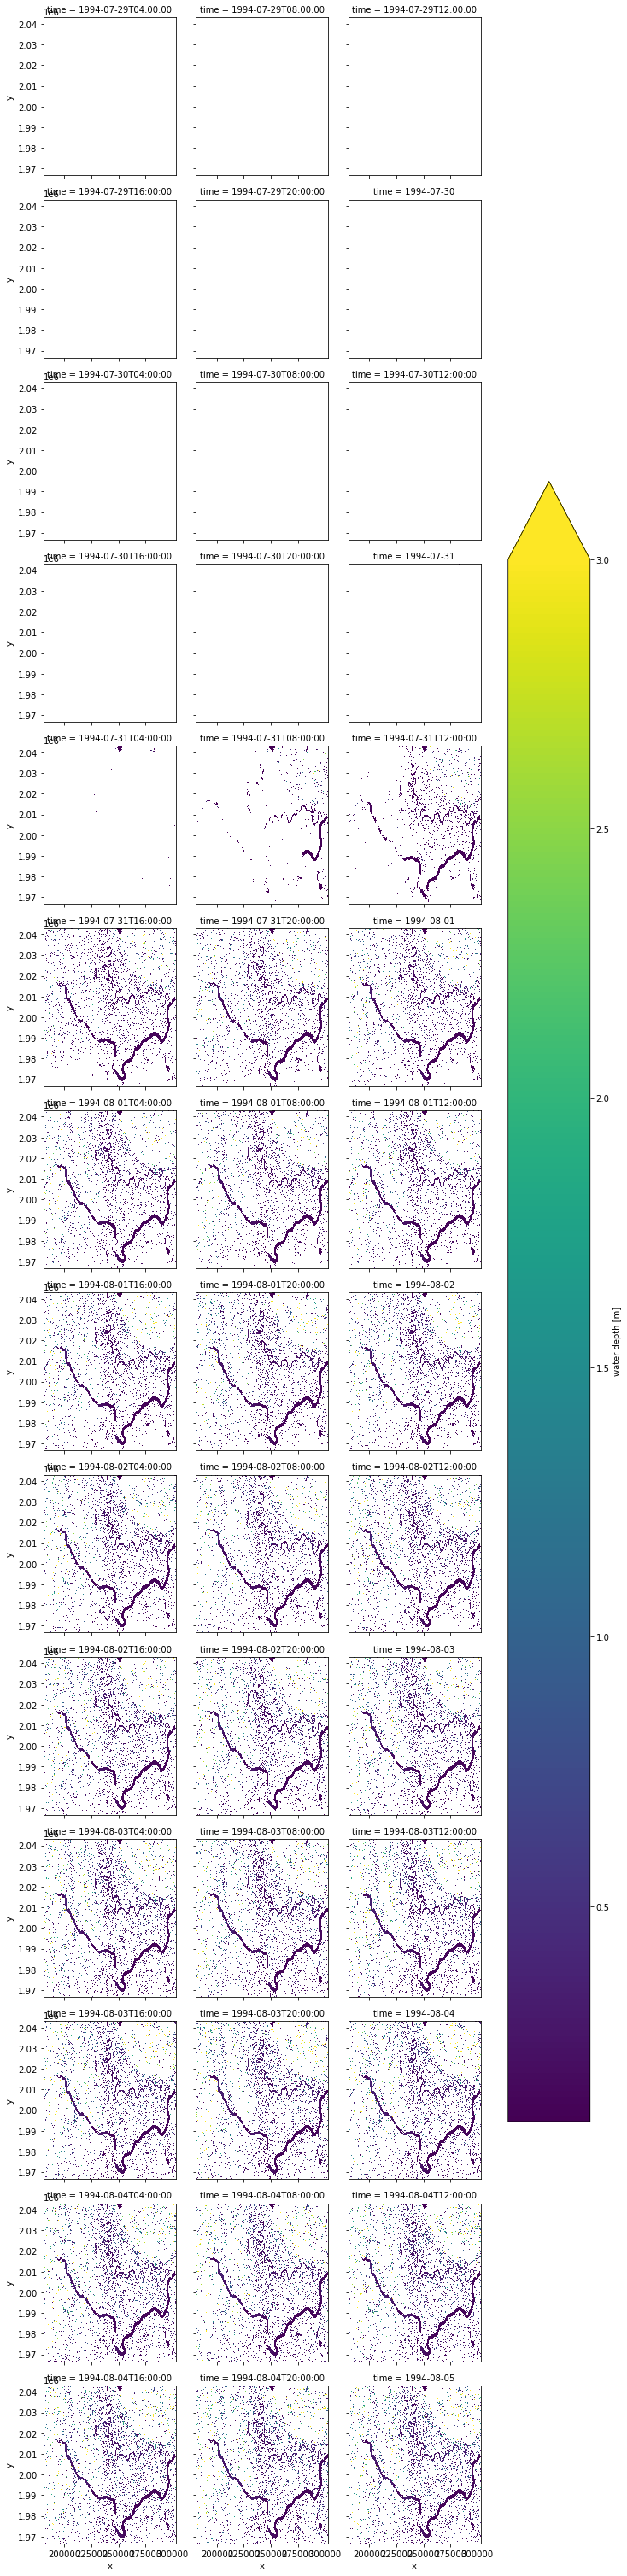

In [3]:
# h from sfincs_map contains the water depths for each cell face
# here we plot the water level every 4th hour

h = mod.results["h"].where(mod.results["h"] > 0.1)
h.attrs.update(long_name="water depth", unit="m")
h.sel(time=h["time"].values[4::4]).plot(col="time", col_wrap=3, vmax=3)

In [4]:
# import dependencies
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import hydromt
from hydromt_sfincs import SfincsModel

In [5]:
sfincs_root = "sfincs_vientiane_model"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r", deltares_data= True)

Overwriting data source era5_hourly.
Overwriting data source gcn250.
Overwriting data source merit_hydro.
Overwriting data source rivers_lin2019_v1.
Overwriting data source vito.


In [6]:
hmax = mod.results['hmax']
hmax = hmax.reindex(y=list(reversed(hmax['y'].values))) # change orientation to N -> S
hmax.raster.to_raster(join(mod.root, 'gis', 'hmax.tif'), compress='LZW')

In [7]:
print(mod.data_catalog["gswo"])
gswo = mod.data_catalog.get_rasterdataset("gswo", buffer=10)
# permanent water where water occurence > 5%
gswo_mask = gswo.raster.reproject_like(mod.staticmaps, method="max") <= 3

{'category': 'hydrography',
 'data_type': 'RasterDataset',
 'driver': 'raster',
 'paper_doi': '10.1038/nature20584',
 'paper_ref': 'Pekel et al. (2016)',
 'path': 'p:\\wflow_global\\hydromt\\hydrography\\gswo\\occur.vrt',
 'source_url': 'https://global-surface-water.appspot.com/download',
 'source_version': 'v1_1_2019'}


nodata value missing for p:\wflow_global\hydromt\hydrography\gswo\occur.vrt


In [8]:
hmin = 0.25  # minimum flood depth [m] to plot
da_hmax = mod.results["hmax"]  # hmax is computed from zsmax - zb
# get overland flood depth with GSWO and set minimum flood depth
da_hmax_fld = da_hmax.where(gswo_mask).where(da_hmax > hmin)
# update attributes for colorbar label later
da_hmax.attrs.update(long_name="flood depth", unit="m")

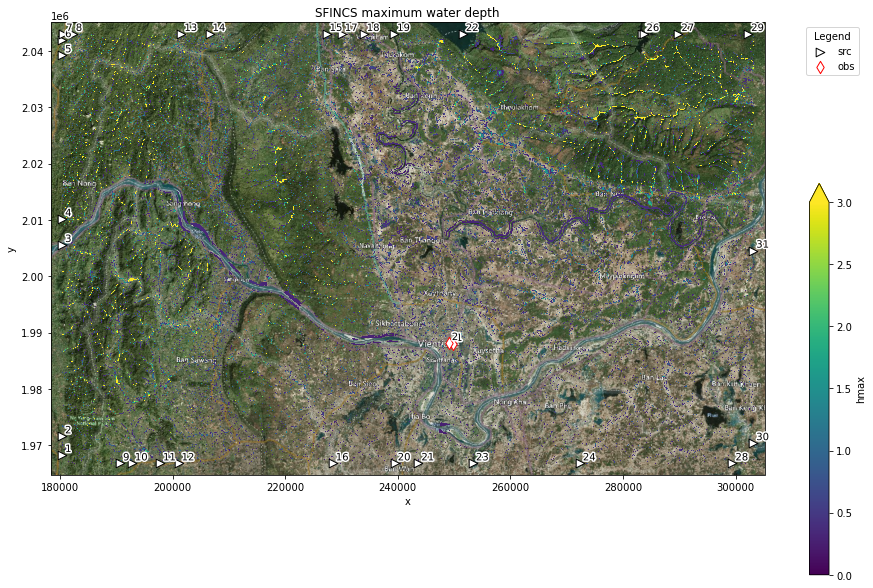

In [9]:
# create hmax plot and save to mod.root/figs/hmax.png
fig, ax = mod.plot_basemap(
    fn_out=None,
    variable=None,
    bmap="sat",
    geoms=["src", "obs"],
    plot_bounds=False,
    figsize=(16, 12),
)
# plot overland flooding based on gswo mask and mimum flood depth
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = da_hmax_fld.plot(
    ax=ax, vmin=0, vmax=3.0, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)

ax.set_title(f"SFINCS maximum water depth")
plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")